In [1]:
import torch
import torchani
from torchani.datasets import ANIDataset
from torchani.units import hartree2kcalmol

import pandas as pd
import time
from tqdm.notebook import tqdm
from pathlib import Path
import re
from ase import Atoms
from ase.visualize import view

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ds_path = Path('/home/nick/First_DSs/ANI-1x-first-conformers.h5')
model = torchani.models.ANIdr().to(device)
ds = ANIDataset(locations=ds_path)

In [3]:
key_list = list(ds.keys())
print('This was the highest uncertainty molecule in the set:', key_list[1476])

This was the highest uncertainty molecule in the set: C4H7N3O5


In [4]:
current = (ds['C4H7N3O5']['species'].to(device), ds['C4H7N3O5']['coordinates'].to(device))
_, magnitudes, rel_range, rel_stdev = model.force_qbc(current, average=True)
print(rel_range.mean(), rel_range.max())
print(rel_stdev.mean(), rel_stdev.max())

tensor(0.1919, device='cuda:0') tensor(1.0536, device='cuda:0')
tensor(0.5271, device='cuda:0') tensor(2.9071, device='cuda:0')


In [5]:
# NOTE: Code to generate dictionary located in a script at /home/nick/Isolate_atoms/run_ani.py

In [6]:
df = pd.read_pickle('/home/nick/Isolate_atoms/1x_first_output_dict.pkl')

In [7]:
original_df = df

In [8]:
df['species'] = original_df['species'].apply(lambda x: x.tolist())
df['coordinates'] = original_df['coordinates'].apply(lambda x: x.tolist())
df['relative_range'] = original_df['relative_range'].apply(lambda x: x.tolist())
df['relative_stdev'] = original_df['relative_stdev'].apply(lambda x: x.tolist())
print('dataframe after conversion to lists:\n', df)

dataframe after conversion to lists:
                                                       species  \
C10H10      [[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,...   
C10H10N2    [[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,...   
C10H10N2O   [[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,...   
C10H10N2O2  [[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,...   
C10H10N4    [[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,...   
...                                                       ...   
N2O3                                        [[7, 7, 8, 8, 8]]   
N4                                             [[7, 7, 7, 7]]   
O2                                                   [[8, 8]]   
O3                                                [[8, 8, 8]]   
O4                                             [[8, 8, 8, 8]]   

                                                  coordinates  \
C10H10      [[[-2.0472970008850098, -0.8264654874801636, 0...   
C10H10N2    [[[2.5130574703216553, -1.7045336961746

In [9]:
# Explode the 'species' column
exploded_species = df['species'].explode().explode().reset_index(drop=True)


# Repeat the other columns to match the length of the exploded 'species' and 'coordinates' columns
other_columns = ['relative_range', 'relative_stdev']
exploded_other_columns = pd.concat([df[col].explode().reset_index(drop=True) for col in other_columns], axis=1)

# Create the final exploded DataFrame
exploded_df = pd.concat([exploded_species, exploded_other_columns], axis=1)


In [10]:
exploded_df

,species,relative_range,relative_stdev
0,6,0.025029,0.073119
1,6,0.053542,0.14944
2,6,0.012345,0.029772
3,6,0.034369,0.0998
4,6,0.015776,0.049525
...,...,...,...
72745,8,0.014113,0.035008
72746,8,0.447976,1.368881
72747,8,0.250151,0.758184
72748,8,0.106566,0.317599


In [11]:
# Count of the species with rel_range and/or rel_stdev:
rel_range_exceeds_1 = exploded_df[exploded_df['relative_range'] > 1]
rel_stdev_exceeds_1 = exploded_df[exploded_df['relative_stdev'] > 1]
rel_range_species_count = rel_range_exceeds_1['species'].value_counts()
rel_stdev_species_count = rel_stdev_exceeds_1['species'].value_counts()
rel_stdev_species_count

species
1    404
7    225
6    206
8    125
Name: count, dtype: int64

In [12]:
#exploded_df.to_csv('exploded_rel_range-rel_stdev_df.csv')
# Already saved, wanted for gpt 


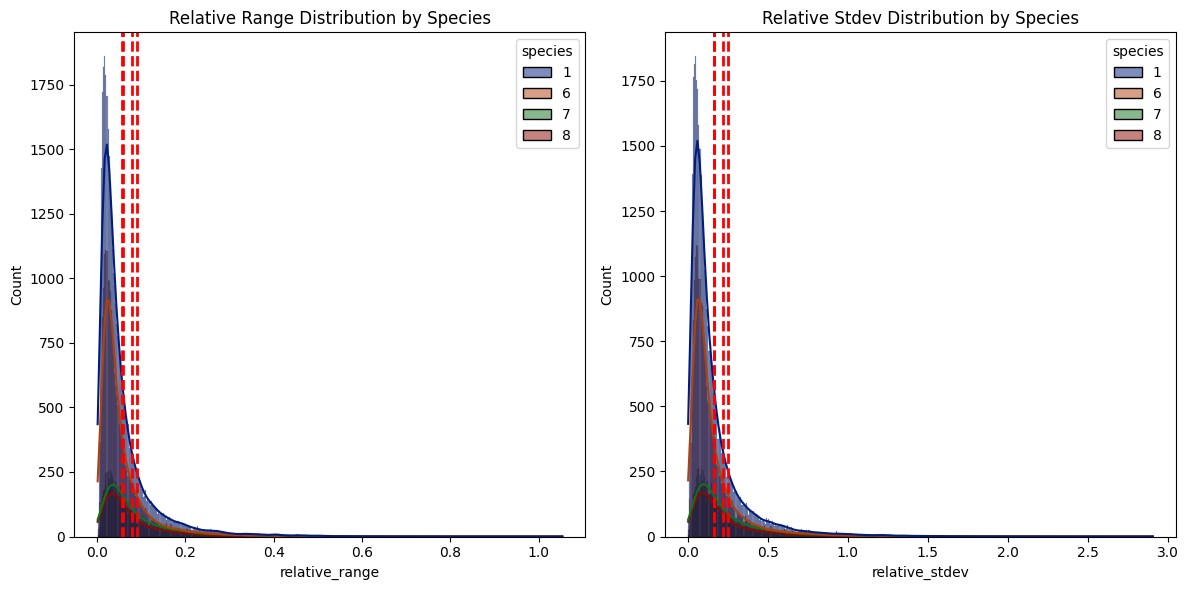

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histograms or density plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=exploded_df, x='relative_range', hue='species', kde=True, palette='dark')
plt.title('Relative Range Distribution by Species')
# Calculate and plot the mean line for 'relative_range'
mean_relative_range = exploded_df.groupby('species')['relative_range'].mean()
for mean in mean_relative_range:
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')



plt.subplot(1, 2, 2)
sns.histplot(data=exploded_df, x='relative_stdev', hue='species', kde=True, palette='dark')
plt.title('Relative Stdev Distribution by Species')
# Calculate and plot the mean line for 'relative_stdev'
mean_relative_stdev = exploded_df.groupby('species')['relative_stdev'].mean()
for mean in mean_relative_stdev:
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')

plt.tight_layout()
plt.show()


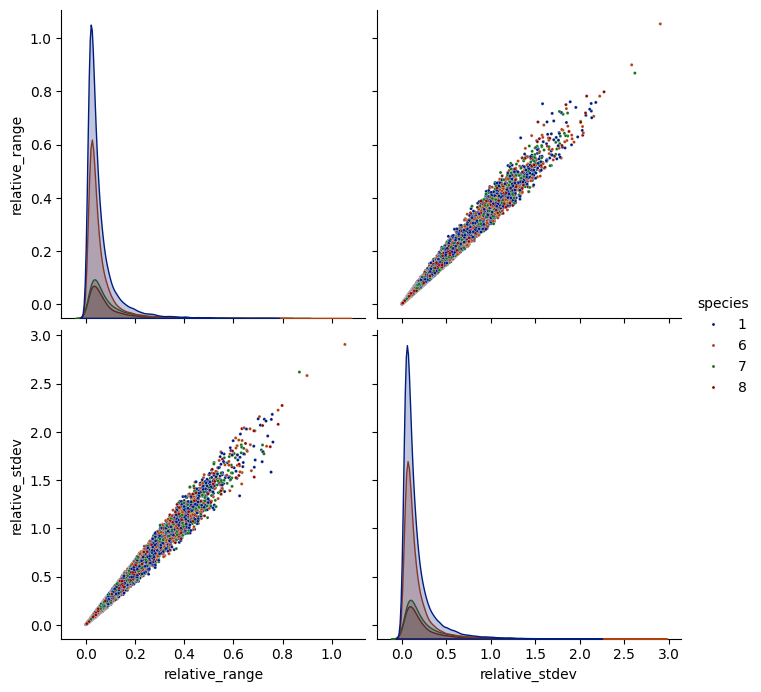

In [14]:
sns.pairplot(data=exploded_df, hue='species', palette='dark', plot_kws={'s': 5}, height=3.5)
#plt.title('Pair Plot of Variables by Species')
plt.show()


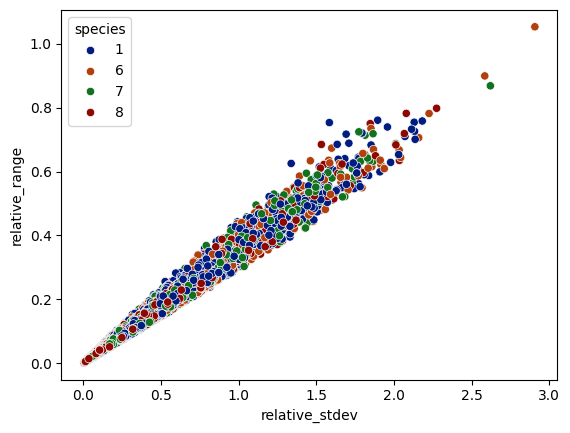

In [16]:
sns.scatterplot(data=exploded_df, x='relative_stdev', y='relative_range', hue='species', palette='dark')#, size=5)
plt.show()

In [128]:
#output_dict['C4H7N3O5']    # This molecule had the highest rel_range of the 1x_first dataset

In [23]:
# This was filtered by things that have a relative_stdev greater than 1 (twenty "worst" structures)
#   The code for this filter is in moria:/home/nick/Code_snippets/dataframe_manipulation_stuff.py

df = pd.read_pickle('/home/nick/Datasets/Pickles/filtered_1x_first_w_stdev.pkl')
print(len(df))

20


In [24]:
type(df['relative_range'][0])

list

In [25]:
def count_ones(lst):
    if isinstance(lst, list):
        return sum(1 for val in lst if val == 1)
    return 0

# Count the total number of 1s in the 'relative_range' column
total_ones = df['relative_stdev'].apply(count_ones).sum()
print('There are', total_ones, 'atoms with a relative_stdev > 2 in the filtered 1x_first dataset')


There are 20 atoms with a relative_stdev > 2 in the filtered 1x_first dataset


In [26]:
df

,species,coordinates,relative_range,relative_stdev
C10H3NO,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-0.9084, device='cuda:0', grad_fn=<U...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
C10H5N,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-6.3169, device='cuda:0', grad_fn=<U...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
C2H3N7O,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-2.2772, device='cuda:0', grad_fn=<U...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
C2H7NO5,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-0.7096, device='cuda:0', grad_fn=<U...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
C2H8N8O,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(1.7153, device='cuda:0', grad_fn=<Un...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
C3H3N7O2,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-3.2583, device='cuda:0', grad_fn=<U...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
C3H5N7,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-3.1023, device='cuda:0', grad_fn=<U...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
C3H8N2O5,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(2.2923, device='cuda:0', grad_fn=<Un...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
C4H7N3O4,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(3.1776, device='cuda:0', grad_fn=<Un...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
C4H7N3O5,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-3.1554, device='cuda:0', grad_fn=<U...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [29]:
for formula, row in df.iterrows():
    species_coord = (row['species'], row['coordinates'])
    force = model.members_forces(species_coord).forces
    #print(len(row['species'][0]))
    #print((force.mean(0))[0])
    print(torchani.units.hartree2kcalmol(force.mean(0).sum()))
    

tensor(2.3377e-06, device='cuda:0')
tensor(1.8701e-05, device='cuda:0')
tensor(9.3506e-06, device='cuda:0')
tensor(2.3377e-06, device='cuda:0')
tensor(7.0130e-06, device='cuda:0')
tensor(4.6753e-06, device='cuda:0')
tensor(-4.6753e-06, device='cuda:0')
tensor(-1.6364e-05, device='cuda:0')
tensor(8.1818e-06, device='cuda:0')
tensor(4.6753e-06, device='cuda:0')
tensor(0., device='cuda:0')
tensor(4.6753e-06, device='cuda:0')
tensor(-9.3506e-06, device='cuda:0')
tensor(-4.6753e-06, device='cuda:0')
tensor(-9.3506e-06, device='cuda:0')
tensor(-4.6753e-06, device='cuda:0')
tensor(-2.3377e-05, device='cuda:0')
tensor(0., device='cuda:0')
tensor(5.8441e-06, device='cuda:0')
tensor(-4.6753e-06, device='cuda:0')


In [30]:
# This is the highest force_qbc.relative_range uncertainty prediction in the 1x_first dataset 
species_coordinates = (ds['C4H7N3O5']['species'].to(device),ds['C4H7N3O5']['coordinates'].to(device))
hartree2kcalmol(model.energies_qbcs(species_coordinates).qbcs.item())

0.3435050637392299

In [31]:
_, magnitudes, rel_range, rel_stdev = model.force_qbc(species_coordinates, average=True)
print(rel_range)

tensor([[0.0431, 0.1562, 0.2287, 1.0536, 0.0558, 0.0879, 0.0578, 0.2076, 0.2375,
         0.0518, 0.0602, 0.0880, 0.1584, 0.1110, 0.0551, 0.3889, 0.2953, 0.1557,
         0.1530]], device='cuda:0')


In [32]:
from ase.visualize import view
from ase import io

In [33]:
print(df.loc['C4H7N3O5']['species'].squeeze().tolist())
print(df.loc['C4H7N3O5']['relative_stdev'])

[6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 8, 8, 8, 8, 8]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [30]:
import nglview as nv
import numpy as np
from PIL import Image

# Assuming you have a DataFrame called 'df' with columns 'species', 'coordinates', and 'relative_stdev'
molecule_data = []

for formula, row in df.iterrows():
    species = row['species'].squeeze().cpu()
    coordinates = row['coordinates'].squeeze().cpu().detach()
    relative_stdev = row['relative_stdev']
    molecule_data.append({
    "name": formula,
    "species": species.tolist(),
    "relative_stdev": relative_stdev
    })
    print(formula)
    print(species.tolist())
    print(relative_stdev)
    print()
    # Create an ASE Atoms object
    atoms = Atoms(symbols=species, positions=coordinates)

    # Create an NGLViewer instance
    viewer = nv.show_ase(atoms)

    # Highlight the atoms with relative_stdev value equal to 1
    highlight_indices = [i for i, val in enumerate(relative_stdev) if val == 1]
    viewer.add_ball_and_stick(selection=highlight_indices, color='purple', radius=0.3)
    viewer.display()
    io.write(f"{formula}.xyz", atoms, format='xyz')
    # Save the viewer as a PNG image
    #viewer.download_image(filename='/home/nick/'+f"{formula}.png")
viewer

C10H3NO
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 7, 8]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

C10H5N
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 7]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

C2H3N7O
[6, 6, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 8]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

C2H7NO5
[6, 6, 1, 1, 1, 1, 1, 1, 1, 7, 8, 8, 8, 8, 8]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

C2H8N8O
[6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 8]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

C3H3N7O2
[6, 6, 6, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 8, 8]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

C3H5N7
[6, 6, 6, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

C3H8N2O5
[6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 8, 8, 8, 8, 8]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

C4H7N3O4
[6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 8, 8, 8, 8]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

C4H7N3O5
[6, 6, 6, 6, 1, 1, 1, 1, 1,

NGLWidget()

In [33]:
df_molecules = pd.DataFrame(molecule_data)
df_molecules.to_csv("molecule_data.csv", index=False)

In [62]:
df_molecules

,name,species,relative_stdev
0,C10H3NO,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 7, 8]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,C10H5N,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 7]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,C2H3N7O,"[6, 6, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 8]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,C2H7NO5,"[6, 6, 1, 1, 1, 1, 1, 1, 1, 7, 8, 8, 8, 8, 8]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,C2H8N8O,"[6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,C3H3N7O2,"[6, 6, 6, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 8, 8]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,C3H5N7,"[6, 6, 6, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
7,C3H8N2O5,"[6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 8, 8, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,C4H7N3O4,"[6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 8, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
9,C4H7N3O5,"[6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 8, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
